# herondata exercise

In [80]:
import calendar
from collections import Counter, defaultdict
import itertools
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
import torch
from transformers import pipeline
import uuid

## load data

In [36]:
def read_transactions(filename):
    with open(filename, 'rt') as fp:
        raw_data = json.load(fp)

    list_of_tx = raw_data['transactions']
    return list_of_tx

def to_df(transactions):
    df = pd.DataFrame(transactions)
    df['date'] = pd.to_datetime(df['date'])
    # df = df.sort_values('date')

    return df


In [37]:
transactions = read_transactions("example.json")
df = to_df(transactions)
df.sample(3)

,description,amount,date
2,Spotify,-14.99,2020-11-29
19,company lunch: barbeque,5.00,2021-01-19
17,company lunch: burritos,5.00,2021-01-05


# explore data

In [38]:
start_date = df.date.iloc[0].date()
end_date = df.date.iloc[-1].date()

print("%s to %s: shape=%s" % (start_date, end_date, df.shape))
df.sample(10)

2021-01-29 to 2020-11-05: shape=(27, 3)


,description,amount,date
4,Netflix,-20.0,2020-02-15
23,one-off meal,-100.0,2021-02-14
5,Netflix,-20.0,2020-03-14
8,Aug2020 Acme Corp Salary,4000.0,2020-08-01
24,special meal,-50.0,2021-01-05
15,Mar2021 Acme Corp Salary,5000.0,2021-03-01
25,special holiday,-5000.0,2020-12-10
14,Feb2021 Acme Corp Salary,5000.0,2021-02-01
16,Apr2021 Acme Corp Salary,5000.0,2021-04-01
17,company lunch: burritos,5.0,2021-01-05


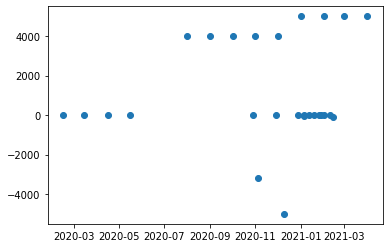

In [39]:
fig, ax = plt.subplots()
ax.scatter(df['date'], df['amount'])
plt.show()

observation: maybe theres 4 or 5 recurring payments in the given dataset?

In [40]:
df.groupby('description').count().query('amount == 1')

,amount,date
description,,
Apr2021 Acme Corp Salary,1,1
Aug2020 Acme Corp Salary,1,1
Dec2020 Acme Corp Salary,1,1
Feb2021 Acme Corp Salary,1,1
Jan2021 Acme Corp Salary,1,1
Mar2021 Acme Corp Salary,1,1
Nov2020 Acme Corp Salary,1,1
Oct2020 Acme Corp Salary,1,1
Sep2020 Acme Corp Salary,1,1


observations:
- acme corp salary has payment date in description
- company lunch maybe recurring

# brainstorming/ideas

define recurring
- similar amt (does sign matter? refunds?)
- same merchant
- payment dates spaced uniformly

need features for ?each of? the above, 
- should these be calculated independently
- should we do:
    - grp(amt, merchant) -> metric(periodicity)
    - grp(amt, periodicity) -> metric(is_same_merchant)
    - grp(amt) -> metric(is_same_merchant)
    - ...
    - then need to combine these somehow

add extra categories to strengthen confidence
- entertainment, food, income, sports

assume this is for forecasting

# cleaning: remove payment dates from description

In [41]:
def _build_month_regex(month_idx):
    # prev.month, current.month, next.month in [1,12]-space
    # (((month_idx - 1) - 1) % 12) + 1, month_idx, ((((month_idx - 1) + 1) % 12) + 1)
    months_re = []
    month_lags = ((month_idx - 2) % 12) + 1, month_idx, (month_idx % 12) + 1
    for m in month_lags:
        months_re.append(calendar.month_name[m])
        months_re.append(calendar.month_abbr[m])

    return '|'.join(months_re).lower()

def clean_payment_dates(df, debug=False):
    df['month_regex'] = df.date.dt.month.apply(_build_month_regex)
    df['year_regex'] = df.date.dt.year.apply(lambda y: f"{y-1}|{y}|{y+1}")

    if debug:
        display(df.sample(n=3))

    df['description'] = (
        df[['description', 'month_regex', 'year_regex']]
        .apply(axis=1,
               func=lambda srs: re.sub(f"{srs.month_regex}|{srs.year_regex}", '', srs.description.lower()).strip())
        )

    df = df.drop(columns=['month_regex', 'year_regex'])
    return df


In [42]:
df = clean_payment_dates(df)
df.sample(n=3)

,description,amount,date
25,special holiday,-5000.0,2020-12-10
5,netflix,-20.0,2020-03-14
18,company lunch: korean,5.0,2021-01-12


# feature: determine periodicity/seasonality of tx

ideas
- acf/autocorrelation
- fourier transform

In [43]:
def _align_timeseries(df_sparse, value_label, date_label='date'):
    df_sparse = df_sparse.sort_values(date_label)
    df_start = df_sparse[date_label].iloc[0].date()
    df_end = df_sparse[date_label].iloc[-1].date()

    df_aligned = (pd
        .DataFrame({date_label: pd.date_range(start=df_start, end=df_end)})
        .set_index(date_label)
        .join(df_sparse[[date_label, value_label]].set_index(date_label))
        .fillna(0)
    )
    
    return df_aligned

def _acf_helper(df_aligned, value_label, title, nlags=35, threshold=0.1, filter_multiples=False, debug=False):
    if debug:
        sm.graphics.tsa.plot_acf(df_aligned[value_label].squeeze(), lags=nlags, title=title)
    df_acf = (pd
        .DataFrame({'acf': sm.tsa.stattools.acf(df_aligned[value_label].squeeze(), nlags=nlags)})
        .sort_values(by='acf', key=abs, ascending=False)
        .query("abs(acf) >= @threshold")
        [1:]
    )
    
    if filter_multiples:
        f = df_acf.index < min(df_acf.index) * 2
        df_acf = df_acf[f]
    return df_acf

,31,30,22,32,28,9
acf,0.351026,0.139985,-0.127588,0.108837,0.106432,-0.103741


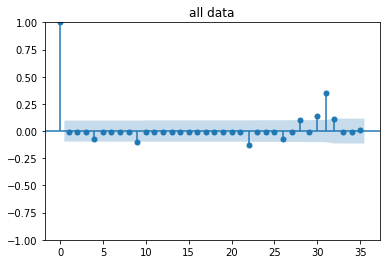

In [44]:
df_aligned = _align_timeseries(df, 'amount')
df_aligned_acf = _acf_helper(df_aligned, 'amount', 'all data', debug=True)
display(df_aligned_acf.T)

In [45]:
def _lag_to_period_category(
    lags, 
    PERIODS = pd.DataFrame({'Q': 365/4, 'M': 365/12, 'F': 14, 'W': 7, 'D': 1}.items(), columns=["period", "lag"])
):
    mean_lag = sum(lags)/len(lags)
    sd_lag = np.std(lags)
 
    p = PERIODS[PERIODS.lag.between(mean_lag - sd_lag, mean_lag + sd_lag)]
    if len(p) == 1:
        return p.iloc[0].period
    
    return uuid.uuid1()

In [46]:
def predict_periods(df, debug=False):
    periods = dict()
    for name, group in df.groupby('amount'):
        if group.shape[0] > 1:
            group_periodicity = _align_timeseries(group, 'amount')
            group_acf = _acf_helper(group_periodicity, 'amount', f"amount={name}", threshold=0.2, filter_multiples=True, debug=debug)
            periods[name] = _lag_to_period_category(group_acf.index)
        else:
            periods[name] = uuid.uuid1()

    periods_by_amount = pd.DataFrame(periods.items(), columns=['amount', 'amt_freq'])
    df = df.merge(periods_by_amount, how='left')

    return df

,description,amount,date,amt_freq
14,acme corp salary,5000.0,2021-02-01,M
12,acme corp salary,4000.0,2020-12-01,M
18,company lunch: korean,5.0,2021-01-12,W
17,company lunch: burritos,5.0,2021-01-05,W
16,acme corp salary,5000.0,2021-04-01,M


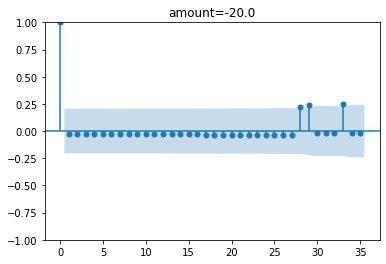

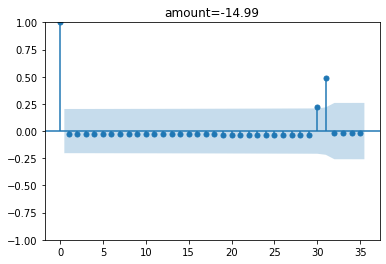

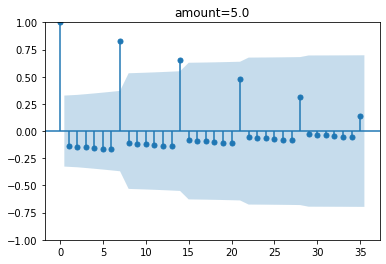

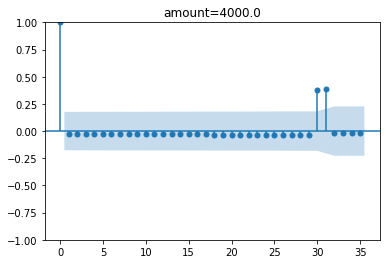

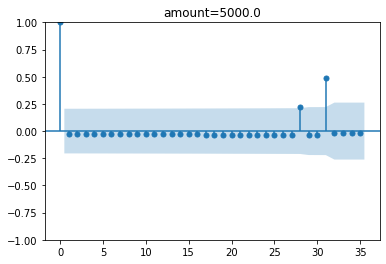

In [47]:
df = predict_periods(df, debug=True)
df.sample(5)

In [48]:
def _add_freq_detail(grp):
    freq = grp.amt_freq.values[0]
    n = len(grp)
    res = 0
    if freq == 'M':
        res = np.average(grp.date.dt.day).astype(int)
        
    if freq == 'W':
        res = np.average(grp.date.dt.dayofweek).astype(int)

    return pd.DataFrame([res] * n, index=grp.index)

def predict_period_frequency(df):
    df['amt_freq_detail'] = (df
        [['date', 'amt_freq', 'amount']]
        .groupby(['amt_freq', 'amount'], as_index=False)
        .apply(_add_freq_detail)
    )
    return df

In [49]:
df = predict_period_frequency(df)
df.sample(3)

,description,amount,date,amt_freq,amt_freq_detail
18,company lunch: korean,5.00,2021-01-12,W,1
7,netflix,-20.00,2020-05-15,M,15
0,spotify,-14.99,2021-01-29,M,29


# feature: categorise transactions

In [50]:
def _setup_classifier(classifier=[]):
    if len(classifier) == 0:
        classifier.append(pipeline('zero-shot-classification', model='facebook/bart-large-mnli'))
    return classifier[0]    

In [51]:
def _predict_category_helper(s):
    classifier = _setup_classifier()
    hypothesis_template = '{}.'
    labels = ["video streaming", "music streaming", "groceries", "sports", "food", "health", "income", "mortgage", "loan", "rent", "phone"]
    desc = s.iloc[0].values[0]
    prediction = classifier(desc, labels, hypothesis_template=hypothesis_template)
    
    n = s.shape[0]
    res = prediction['labels'][0]
    return pd.DataFrame([res] * n, index=s.index)

def predict_category(df):
    df['category'] = df[['description']].groupby('description').apply(_predict_category_helper)
    return df

In [71]:
df = predict_category(df)
df

,description,amount,date,amt_freq,amt_freq_detail,category
0,spotify,-14.99,2021-01-29,M,29,music streaming
1,spotify,-14.99,2020-12-29,M,29,music streaming
2,spotify,-14.99,2020-11-29,M,29,music streaming
3,spotify,-14.99,2020-10-29,M,29,music streaming
4,netflix,-20.00,2020-02-15,M,15,video streaming
5,netflix,-20.00,2020-03-14,M,15,video streaming
6,netflix,-20.00,2020-04-16,M,15,video streaming
7,netflix,-20.00,2020-05-15,M,15,video streaming
8,acme corp salary,4000.00,2020-08-01,M,1,income
9,acme corp salary,4000.00,2020-09-01,M,1,income


In [65]:
# def identify_recurring_transactions(transactions: List[Transaction]) -> List[Transaction.id]:
def identify_recurring_transactions(transactions, ids_only=True):
    df = to_df(transactions)
    df = clean_payment_dates(df)
    df = predict_periods(df)
    df = predict_period_frequency(df)
    df = predict_category(df)

    recurring_tx = []
    for n, grp in df.groupby(['amt_freq', 'amt_freq_detail', 'category']):
        if len(grp) >= 3:
            if ids_only:
                grp_res = list(grp.index)
            else:
                grp_res = grp[['date', 'description', 'amount']]

            recurring_tx.append(grp_res)

    return recurring_tx

In [69]:
result = identify_recurring_transactions(read_transactions('example.json'), ids_only=False)

In [68]:
result

[[8, 9, 10, 11, 12, 13, 14, 15, 16],
 [4, 5, 6, 7],
 [0, 1, 2, 3],
 [17, 18, 19, 20, 21, 22]]

In [70]:
for r in result:
    display(r)

,date,description,amount
8,2020-08-01,acme corp salary,4000.0
9,2020-09-01,acme corp salary,4000.0
10,2020-10-01,acme corp salary,4000.0
11,2020-11-01,acme corp salary,4000.0
12,2020-12-01,acme corp salary,4000.0
13,2021-01-01,acme corp salary,5000.0
14,2021-02-01,acme corp salary,5000.0
15,2021-03-01,acme corp salary,5000.0
16,2021-04-01,acme corp salary,5000.0


,date,description,amount
4,2020-02-15,netflix,-20.0
5,2020-03-14,netflix,-20.0
6,2020-04-16,netflix,-20.0
7,2020-05-15,netflix,-20.0


,date,description,amount
0,2021-01-29,spotify,-14.99
1,2020-12-29,spotify,-14.99
2,2020-11-29,spotify,-14.99
3,2020-10-29,spotify,-14.99


,date,description,amount
17,2021-01-05,company lunch: burritos,5.0
18,2021-01-12,company lunch: korean,5.0
19,2021-01-19,company lunch: barbeque,5.0
20,2021-01-26,company lunch: hot pot,5.0
21,2021-02-02,company lunch: fondue,5.0
22,2021-02-09,company lunch: burgers,5.0


# additional code (out of time)

## feature: capture similarity of descriptions

- measure similarity of desc within amt group
- somethign with topics
- distance of each description to another description - false positives
 

In [74]:
df['desc_words'] = df.description.str.split('[:,;\s]', regex=True)
df.sample(n=5)

,description,amount,date,amt_freq,amt_freq_detail,category,desc_words
13,acme corp salary,5000.0,2021-01-01,M,1,income,"[acme, corp, salary]"
7,netflix,-20.0,2020-05-15,M,15,video streaming,[netflix]
5,netflix,-20.0,2020-03-14,M,15,video streaming,[netflix]
8,acme corp salary,4000.0,2020-08-01,M,1,income,"[acme, corp, salary]"
15,acme corp salary,5000.0,2021-03-01,M,1,income,"[acme, corp, salary]"


In [81]:
desc_word_counts = Counter(itertools.chain.from_iterable(df.desc_words))
del desc_word_counts['']
total_words = sum(desc_word_counts.values())
desc_word_freq = defaultdict(lambda: 0, {w: count for w, count in desc_word_counts.items() if count > 1})
desc_word_freq

defaultdict(<function __main__.<lambda>()>,
            {'spotify': 4,
             'netflix': 4,
             'acme': 9,
             'corp': 9,
             'salary': 9,
             'company': 6,
             'lunch': 6,
             'meal': 2,
             'special': 2})

In [82]:
def calcSimilarityScore(srs):
    desc_similarity = sum(list(map(lambda m: desc_word_freq[m], srs.desc_words)))/total_words
    similarity = desc_similarity
    return similarity


df['similarity'] = df.apply(calcSimilarityScore, axis=1)
df

,description,amount,date,amt_freq,amt_freq_detail,category,desc_words,similarity
0,spotify,-14.99,2021-01-29,M,29,music streaming,[spotify],0.064516
1,spotify,-14.99,2020-12-29,M,29,music streaming,[spotify],0.064516
2,spotify,-14.99,2020-11-29,M,29,music streaming,[spotify],0.064516
3,spotify,-14.99,2020-10-29,M,29,music streaming,[spotify],0.064516
4,netflix,-20.00,2020-02-15,M,15,video streaming,[netflix],0.064516
5,netflix,-20.00,2020-03-14,M,15,video streaming,[netflix],0.064516
6,netflix,-20.00,2020-04-16,M,15,video streaming,[netflix],0.064516
7,netflix,-20.00,2020-05-15,M,15,video streaming,[netflix],0.064516
8,acme corp salary,4000.00,2020-08-01,M,1,income,"[acme, corp, salary]",0.435484
9,acme corp salary,4000.00,2020-09-01,M,1,income,"[acme, corp, salary]",0.435484


## feature: need to allow for some changes in prices

ideas
- price change due to noise - e.g. purchase item in another ccy
  - rolling mean - e.g. purchase of items in other currencies
- subscriptions might increase 
  - is change in amount over time monotonic
- loan payments might decrease (e.g., mortgage)
=> maybe have a measure of monotonicity

In [83]:
df = (df
    .groupby('description', as_index=False)
    .apply(func=lambda srs: pd.Series({'is_monotonic': srs.amount.is_monotonic}))
    .merge(df)
)

df.sample(3)

,description,is_monotonic,amount,date,amt_freq,amt_freq_detail,category,desc_words,similarity
18,netflix,True,-20.0,2020-05-15,M,15,video streaming,[netflix],0.064516
5,acme corp salary,True,5000.0,2021-01-01,M,1,income,"[acme, corp, salary]",0.435484
6,acme corp salary,True,5000.0,2021-02-01,M,1,income,"[acme, corp, salary]",0.435484


In [86]:
# eps_dict = defaultdict(lambda: 0.1, {
#     'salary': 0.25
# })

# eps = 0.1
# value_brackets = [(x * (1-eps), x* (1+eps))  for x in df['amount'].unique()]
# value_brackets

In [84]:
var_floor = 0.01

df[['amt_mean', 'amt_var']] = (df
    .groupby('description', as_index=False)['amount']
    .rolling(4, min_periods=1)
    .agg({"amt_mean": "mean", "amt_var": "var"})
    .droplevel('description')
)

df['amt_var'] = (df
    [['amt_var']]
    .fillna(var_floor)
    .replace(0, 1)
)


# (df
#     [['description', 'amount', 'amt_var']]
#      .groupby('description')
#      .apply(lambda x: print(x.amount/x.amt_var))
#     # .apply(axis=1, func=lambda s: print(s))
# )


# df.sample(10)

# misc notes

- why company lunch +£5
- salary - diff?
- forecast next month
- probably want to process this as a timeseries, starting from zero knowlege, read one at a time, add confidence to certain transactions
- what if there is a duplicate transaction on same date
- might have a one-off payment inside a subscription
- bank transaction mistakes - duplicate items


- measures of confidence